# Morris-Lecar Model

Model is described using two variables V and n.

$${Cm}\frac{dV}{dt} = {I_{app}} - {g_{l}}({V} - {E_{l}}) -{g_{k}}{n}({V} - {E_{k}}) - {g_{Ca}}{m_{\infty}}({V} - {E_{Ca}})$$


$$\frac{dn}{dt} = \frac{\phi({n_{\infty}(V)} - {n})} {\tau_{n}(V)}  $$

$$ {m_{\infty}(V)} = \frac{1}{2}(1 + {\tanh(\frac{V - V1}{V2})})  $$
$$ {n_{\infty}(V)} = \frac{1}{2}(1 + {\tanh(\frac{V - V3}{V4})})  $$
$$ {\tau_{n}(V)} = \frac{1}{\cosh(\frac{V - V3}{2V4})} $$
Here we are taking V as var1 and n as var2 in the code

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

In [16]:
def get_next_state(prev_state,model_params,dt):
# Each state is a pair (var1,var2) describing current value of DE variables
#      d (var1)/dt = f(var1, var2)
#      d (var2)/dt =  g(var1,var2)
    phi,gca,V3,V4,eca,ek,el,gk,gl,V1,V2,cm,I = model_params
    minf = 0.5*(1 + np.tanh((prev_state[0] - V1)/V2))
    ninf = 0.5*(1 + np.tanh((prev_state[0] - V3)/V4))
    ntau = 1/(np.cosh((prev_state[0] - V3)/(2*V4)))
    curr_state = np.zeros(2)
    curr_state[0] = prev_state[0] + dt*(I - gl*(prev_state[0] - el)- gk*prev_state[1]*(prev_state[0]-ek) - gca*minf*(prev_state[0] - eca))/cm
    curr_state[1] = prev_state[1] + dt*(phi*(ninf - prev_state[1])/ntau)
    return curr_state

In [17]:
# get all values of var2 for the given range of var1 when d (var1)/dt = 0
def get_var1_nullcline(model_params,var1_range):
    phi,gca,V3,V4,eca,ek,el,gk,gl,V1,V2,cm,I = model_params
    var1_nullcline = np.zeros(len(var1_range))
    for i in range(len(var1_range)):
        minf = 0.5*(1 + np.tanh((var1_range[i] - V1)/V2))
        var1_nullcline[i] = (I - gl*(var1_range[i] - el) - gca*minf*(var1_range[i] - eca))/(gk*(var1_range[i] - ek))
    return var1_nullcline

In [18]:
# get all values of var2 for the given range of var1 when d (var2)/dt = 0
def get_var2_nullcline(model_params,var1_range):
    phi,gca,V3,V4,eca,ek,el,gk,gl,V1,V2,cm,I = model_params
    var2_nullcline = np.zeros(len(var1_range))
    for i in range(len(var1_range)):
        var2_nullcline[i] = 0.5 * (1 + np.tanh((var1_range[i]-V3)/V4))
    return var2_nullcline

In [19]:
def find_freq(states):
    var1=states[:,0]
    freq=len(find_peaks(var1)[0])
    if freq>0:
        T = 2000
        tscale = T/freq
        fscale = 1/tscale
    else:
        fscale=0
    return fscale

In [20]:
def get_state(states,params,dt):
    for i in range(1,states.shape[0]):
        states[i,:] = get_next_state(states[i-1,:],params,dt)
    return states

In [21]:
def get_state_I_f(states,params,dt,start_current,end_current):
    state_I = []
    state_f = []
    for current in range(start_current,end_current):
        params[-1]=current
        states = get_state(states,params,dt)
        state_I.append(current)
        freq=find_freq(states)
        state_f.append(freq)
    return state_I,state_f,states

In [22]:
def plot_nullclines_states(states,range1,range2,param,tstop,dt,str):
    phi,gca,V3,V4,eca,ek,el,gk,gl,V1,V2,cm,I = param
        # Create a figure with two pairs of axes for phase plot and time plot
    fig = plt.figure(figsize = [16,8])
    fig.suptitle(f'Morris-Lecar Neuron Model with {str} bifurcation and phi={phi}, gca= {gca}, V3={V3}, V4={V4}, eca={eca}, ek= {ek}, el={el}, gk={gk}, gl= {gl}, V1= {V1}, V2={V2}, Cm ={cm}, I ={I}',fontsize=20)
    phax = fig.add_axes([.075,.1,.4,.8])
    timax = fig.add_axes([.55,.1,.4,.8])
    # Display nullcline and trajectory of neuron in phase space
    phax.plot(range1,get_var1_nullcline(param,range1),color='darkorange',linewidth=3,label='V-nullcline')
    phax.plot(range1,get_var2_nullcline(param,range1),color='darkgreen',linewidth=3,label='n-nullcline')
    phax.plot(states[:,0],states[:,1],color='slateblue',linewidth=3,label='neuron trajectory')

    # Display trajectory of var1 and var2 with time
    timax.plot(np.arange(0,tstop,dt),states[:,0],color='slateblue',linewidth=3,label='V')
    timax.plot(np.arange(0,tstop,dt),states[:,1],color='maroon',linewidth=3,label='n')
    # Set legends and other graph parameters
    phax.set_xlabel('V')
    phax.set_ylabel('n')
    timax.set_xlabel('Time')
    timax.set_ylabel('V/n')
    phax.set_xlim(min(range1),max(range1))
    phax.set_ylim(min(range2),max(range2))
    phax.legend(loc=0)
    timax.legend(loc=0)
    plt.show()

In [23]:
def plot_freq_I(state_I,state_f):    
    fig2 = plt.figure(figsize=(12,8))
    fiax = fig2.add_subplot(111)
    fiax.plot(state_I,state_f,color='maroon',linewidth=3)
    fiax.set_xlabel('I')
    fiax.set_ylabel('f')
    fiax.set_title('Frequency vs Current')
    plt.show()    

In [24]:
tstop = 2000 # time to simulate
dt = .1 #ms discrete time step
range1 = np.arange(-65,50,1)
range2 = np.arange(-.1,.6,.01)
states = np.zeros((int(tstop/dt),2)) 

In [25]:
#phi,gca,V3,V4,eca,ek,el,gk,gl,V1,V2,cm,I
params_snlc = [0.067,4,12,17.4,120,-84,-60,8,2,-1.2,18,20,40] #SNLC
params_hopf = [0.04,4.4,2,30,120,-84,-60,8,2,-1.2,18,20,90] #Hopf
params_homoclinic = [0.23,4,12,17.4,120,-84,-60,8,2,-1.2,18,20,40] #Homoclinic

## Definitions

### Type I neurons
Neuron models with continuous f-I curve are called type I. Type I neurons exhibit regular spiking behavior, that means they generate a single action potential in response to a sustained input current. The behavior of type I neurons in the Morris-Lecar model can be explained using the saddle-node on a limit cycle (SNLC) bifurcation.

SNLC bifurcation occurs when a limit cycle collides with a saddle point (an unstable equilibrium point) and disappears. This results in the creation of a stable equilibrium point and a new unstable limit cycle.

### Type II neurons
Neuron models with discontinuous f-I curve are called type II. Type II neurons exhibit bursting behavior, that means they generate a series of action potentials in response to a sustained input current. The behavior of type II neurons in the Morris-Lecar model can be explained using the Hopf bifurcation.

Hopf bifurcation occurs when a fixed point (an equilibrium point) of a dynamical system becomes unstable, and a limit cycle appears. This limit cycle can be stable or unstable, depending on the parameters of the system.

## Type - I neuron ( SNLC Bifurcation)

At low input currents, the system is in a stable equilibrium state with no spiking behavior. As the input current is increased, the equilibrium point becomes unstable, and a limit cycle appears in the phase space of the system. This corresponds to the onset of spiking behavior in the neuron.

As the input current is further increased, the limit cycle undergoes the SNLC bifurcation and disappears, leading to the creation of a new stable equilibrium point. This leads to stoping of spiking behavior in the neuron.

Type I neurons in morris lecar are characterized by a stable fixed point or equilibrium state. This means if there is no input current the membrane potential will settle to resting membrane potential.

Here in the f-I plot we an clearly see for values from 30 to approx 38 the frequency is 0 but then it increases as the current increases. It'a a continuous curve representing the Type-I neuron.
Also in the voltage curve we can observe there are single spikes at regular intervals.

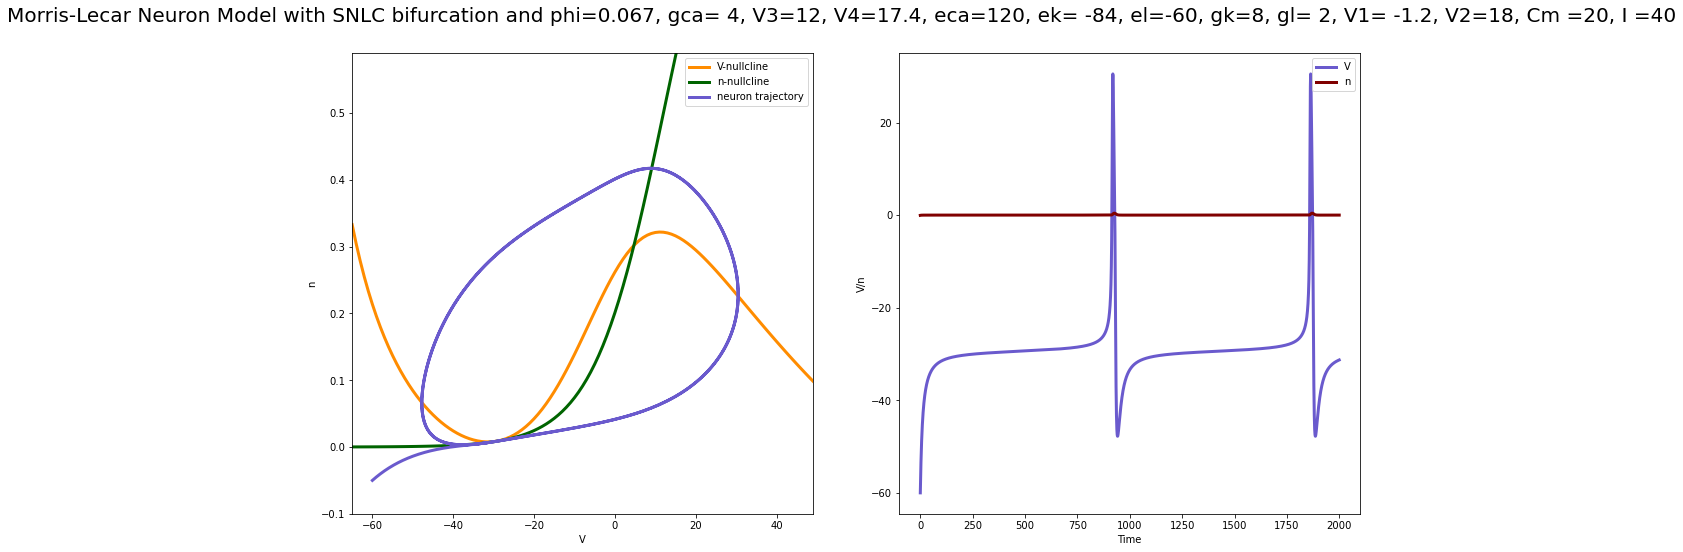

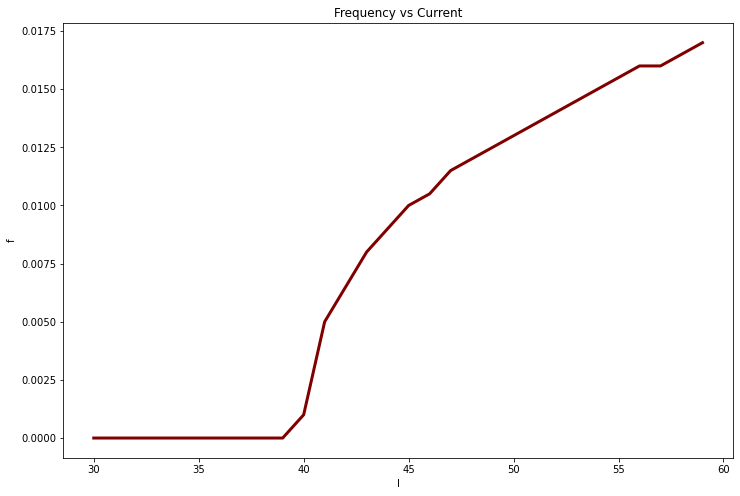

In [26]:
state_I = []
state_f = []
states[0] = [-60,-0.05]
states = get_state(states,params_snlc,dt)
plot_nullclines_states(states,range1,range2,params_snlc,tstop,dt,"SNLC")
state_I,state_f,states = get_state_I_f(states,params_snlc.copy(),dt,30,60)
plot_freq_I(state_I,state_f)

## Tpye - II neuron (Hopf Bifurcation)
As the input current is increased, the stable fixed point loses stability and as we further increase current a stable limit cycle forms. So the neuron undergo a Hopf bifurcation.

At the bifurcation point, the neuron's membrane potential begins to oscillate with increasing amplitude, resulting in the emergence of bursting behavior, where the neuron produces a series of spikes. The amplitude of these burst can increase with increasing current or vice versa.

Type II neurons in morris-lecar are characterized by a stable fixed point and an unstable limit cycle. This means if there is no input current, the neuron's membrane potential will settle into a steady state value, but if the neuron is perturbed slightly, its membrane potential will oscillate in a damped manner, eventually returning to the steady state value.

Here in the f-I plot we an clearly see that as we increase current frequency is fixed for some range of current then it suddenly jumps these jumps are representing the discontinuity in the curve which is exactly the behaviour of Type II neurons.

In the voltage curve we can observe the bursting.

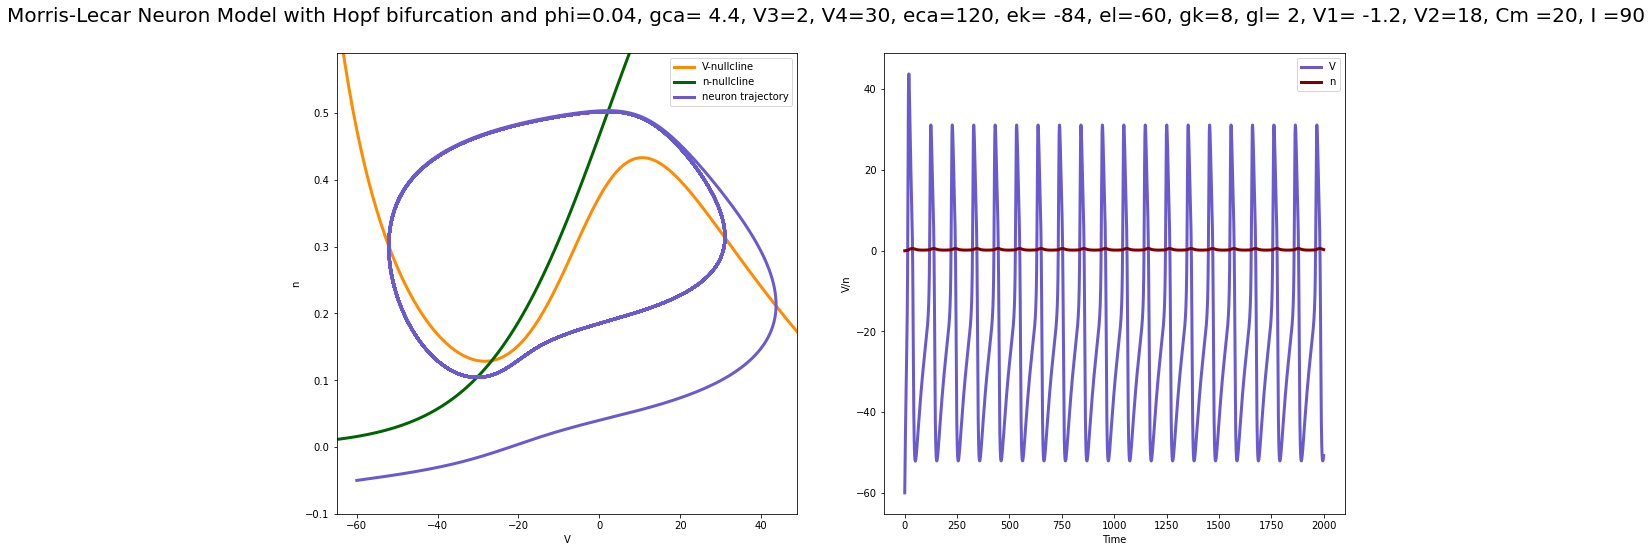

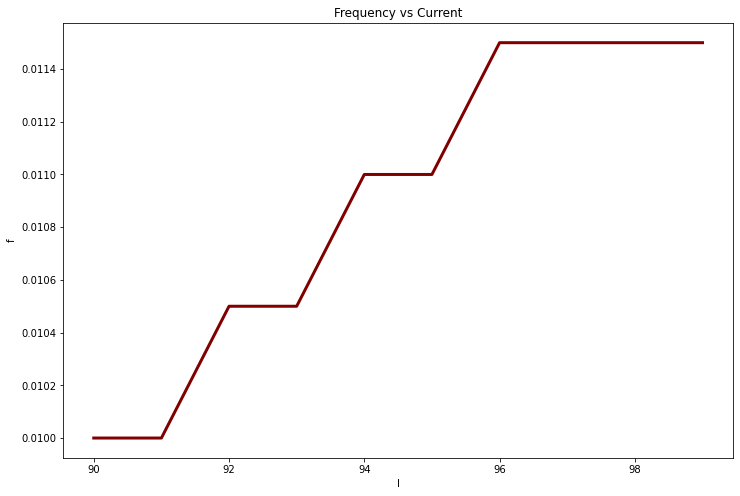

In [27]:
state_I = []
state_f = []
states[0] = [-60,-0.05]
states = get_state(states,params_hopf,dt)
plot_nullclines_states(states,range1,range2,params_hopf,tstop,dt,'Hopf')
state_I,state_f,states = get_state_I_f(states,params_hopf.copy(),dt,90,100)
plot_freq_I(state_I,state_f)

## Homoclinic Bifurcation
Homoclinic bifurcation occurs in nonlinear dynamical systems when a saddle equilibrium point of the system collides with its stable and unstable manifolds. 

In Morris-Lecar model, the homoclinic bifurcation leads to emergence of complex, irregular oscillatory behavior in the neuron.

Here in the voltage plot we can observe first there was no spike and votage keep on incresing with time and suddenly we got the bursting. So it's all irregular in the homoclinic bifurcation.

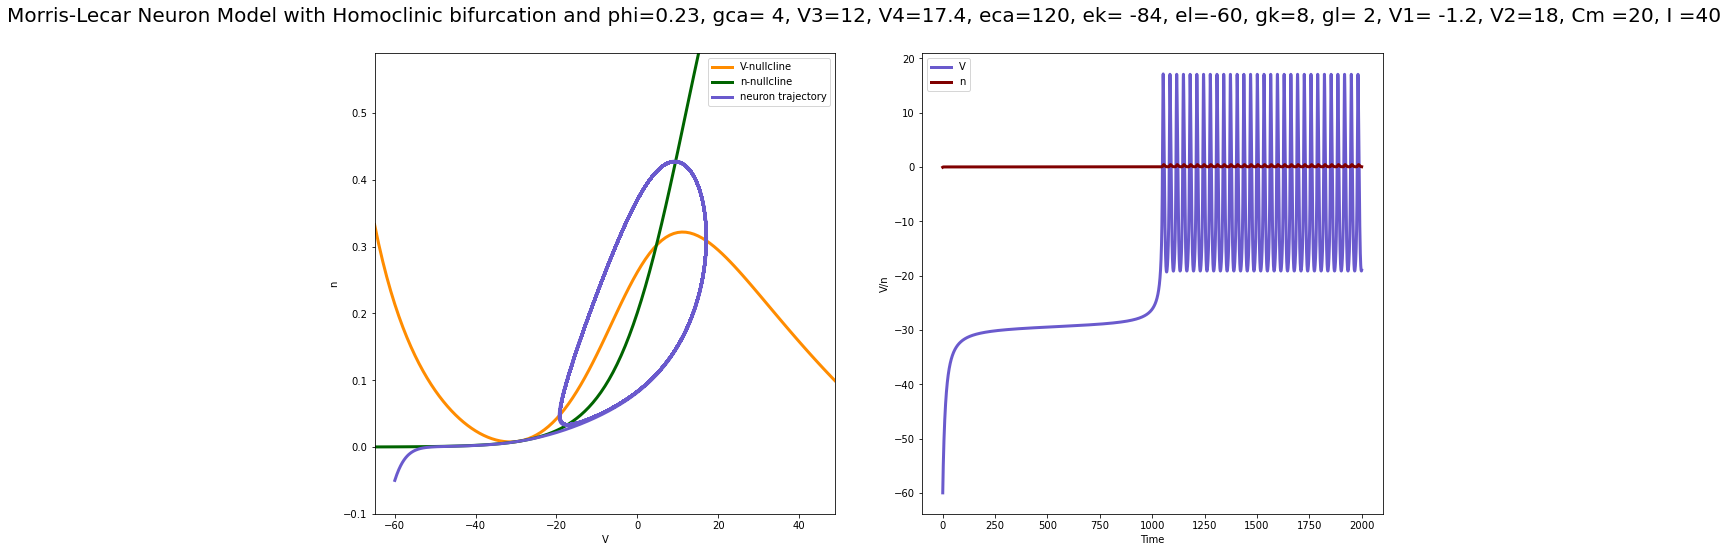

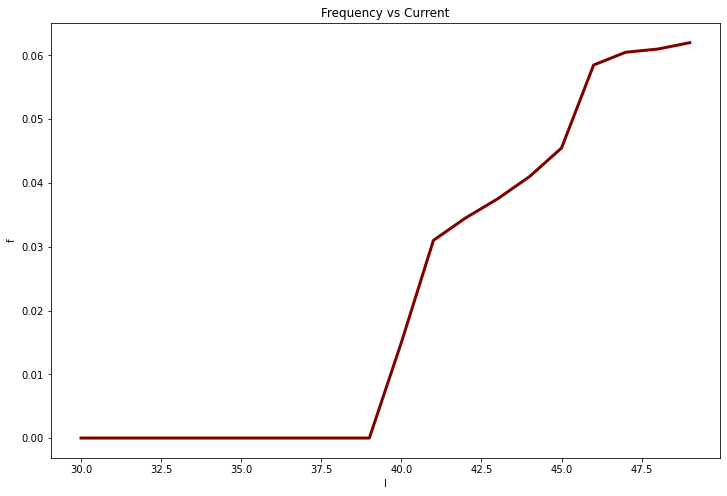

In [28]:
state_I = []
state_f = []
states[0] = [-60,-0.05]
states = get_state(states,params_homoclinic,dt)
plot_nullclines_states(states,range1,range2,params_homoclinic,tstop,dt,"Homoclinic")
state_I,state_f,states = get_state_I_f(states,params_homoclinic.copy(),dt,30,50)
plot_freq_I(state_I,state_f)